In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PriorVAE: Comparisons of scaling

In [8]:
from jax import random
import jax.numpy as jnp

import time
import dill
from flax import serialization

# Numpyro
import numpyro
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive


In [9]:
experiments = ["11_exp4"]


if True:
    path = "./learnt_models/11/09_args_rqk_grid.dill" 
    name_fn = lambda a,l: f"mmd_rqk_sum:{l},{a}"
    a_label = "alpha/scale"
    l_label = "lengthscale"

if False:
    path = "" 
    name_fn = None
    s_label = ""
    t_label = ""




In [10]:
from reusable.util import decoder_filename, get_savepath
import matplotlib.pyplot as plt
from plotting.plots import plot_training,  plot_draws, plot_draws_hpdi
from flax.core.frozen_dict import freeze
from reusable.gp import OneDGP
from reusable.vae import vae_sample

from reusable.vae import VAE



rng_key_gp, rng_key_predict = random.split(random.PRNGKey(2))


plot_gp_predictive = Predictive(OneDGP, num_samples=1000)



In [72]:
from reusable.util import update_args_11

def plot_experiment(experiment, threeIndexing=False):
    with open(f"./learnt_models/11/{experiment}_args.dill", "rb") as f:
        temp_args = dill.load(f)

    gp_draws = plot_gp_predictive(rng_key_gp, x=temp_args["x"], gp_kernel = temp_args["gp_kernel"], jitter=1e-5)['y']


    exp_args = temp_args[experiment]
    

    aL = len(exp_args["Arange"])
    bL = len(exp_args["Brange"]) 

    for loss_fn in temp_args["loss_fns"]:

        training_fig, training_axs = plt.subplots(nrows=aL, ncols=bL, figsize=(bL * 6, aL * 5))
        training_fig.suptitle(f"{experiment}: row:{exp_args['Adesc']}, col:{exp_args['Bdesc']}Test/train for loss fn {loss_fn}", fontsize=40)

        comp_fig, comp_axs = plt.subplots(nrows=aL + 1, ncols=bL, figsize=(bL * 6, aL * 5 + 5))
        comp_fig.suptitle(f"{experiment}: row:{exp_args['Adesc']}, col:{exp_args['Bdesc']} comparison plots for {loss_fn}", fontsize=40)

        plot_draws_hpdi(gp_draws, temp_args["x"], f"GP draws", "$y=f_{GP}(x)$", ax=comp_axs[0, 0])
 

        for i, a in enumerate(exp_args["Arange"]):
            for j, b in enumerate(exp_args["Brange"]):
                with open(f"./learnt_models/11/{experiment}_args.dill", "rb") as f:
                    # so we get a new copy for each one!
                    args = dill.load(f)

                args = update_args_11(args, experiment, i, j)

                index = i + j * aL
                if threeIndexing:
                    name = f"{loss_fn}_{experiment}_{i}_{j}"
                    args["num_epochs"] = temp_args["num_epochs"] # due to error updating arguments 
                else:
                    name = f"{loss_fn}_{experiment}_{index}"
                file_path = f'{get_savepath()}/{decoder_filename("11/11", args, suffix=name)}'
                
                try: 
                    with open(file_path + "_metrics_hist", 'rb') as file:
                        metrics_history = dill.load(file)
                    

                    plot_training(
                        metrics_history["test_loss"], 
                        metrics_history["train_loss"], 
                        f"Test/train loss for {exp_args['Adesc']}={a}, {exp_args['Bdesc']}={b}",
                        "loss",
                        training_axs[i,j]
                    )

                    dummy = VAE(
                        hidden_dim1=args["hidden_dim1"], hidden_dim2=args["hidden_dim2"], latent_dim=args["latent_dim"], out_dim=args["n"], conditional=False
                    )
                    dummy_params = dummy.init(random.PRNGKey(0), jnp.ones((args["latent_dim"],)))

                    with open(file_path, "rb") as file:
                        bytes = file.read()
                        # serialization.to_bytes(freeze({"params": final_state.params["VAE_Decoder_0"]})))
                        #new_dummy  =  freeze({"params" : dummy_params})
                        new_state =  serialization.from_bytes(dummy_params, bytes)
                        args["decoder_params"] = freeze({"params": new_state["params"]["VAE_Decoder_0"]})

                    plot_vae_predictive = Predictive(vae_sample, num_samples=1000)
                    vae_draws = plot_vae_predictive(
                        rng_key_predict,
                        hidden_dim1=args["hidden_dim1"],
                        hidden_dim2=args["hidden_dim2"],
                        latent_dim=args["latent_dim"],
                        out_dim=args["n"],
                        decoder_params=args["decoder_params"],
                    )["f"]

                    plot_draws_hpdi(vae_draws, args["x"], f"{exp_args['Adesc']}={a}, {exp_args['Bdesc']}={b}", "$y=f_{VAE}(x)$", ax=comp_axs[i+1, j])



                except FileNotFoundError:
                    print(f"Failed to load a={a}, b={b}, path = {file_path}")

# Grid of training plots

In [74]:
plot_experiment("11_exp4")

{'n': 100, 'gp_kernel': <function esq_kernel at 0x7f5d884b0c10>, 'rng_key': Array([0, 2], dtype=uint32), 'x': Array([0.        , 0.01      , 0.02      , 0.03      , 0.04      ,
       0.05      , 0.06      , 0.07      , 0.08      , 0.09      ,
       0.09999999, 0.11      , 0.12      , 0.13      , 0.14      ,
       0.14999999, 0.16      , 0.17      , 0.17999999, 0.19      ,
       0.19999999, 0.21      , 0.22      , 0.22999999, 0.24      ,
       0.25      , 0.26      , 0.26999998, 0.28      , 0.29      ,
       0.29999998, 0.31      , 0.32      , 0.32999998, 0.34      ,
       0.35      , 0.35999998, 0.37      , 0.38      , 0.39      ,
       0.39999998, 0.41      , 0.42      , 0.42999998, 0.44      ,
       0.45      , 0.45999998, 0.47      , 0.48      , 0.48999998,
       0.5       , 0.51      , 0.52      , 0.53      , 0.53999996,
       0.55      , 0.56      , 0.57      , 0.58      , 0.59      ,
       0.59999996, 0.61      , 0.62      , 0.63      , 0.64      ,
       0.65      , 

In [68]:
import numpy as onp
from plotting.plots import plot_times_matrix, plot_times_graph


def correct_timing(history, prev_hists):
    """Issue: epoch (and batch times), reset every so often, as I didn't add the times up when rerunning the training"""
    if len(prev_hists) == 0:
        return history

    history["epoch_times"] = history["epoch_times"] + prev_hists[-1]["epoch_times"][-1]
    history["batch_times"] = history["batch_times"] + prev_hists[-1]["epoch_times"][-1]

    return history


def plot_experiment_times(experiment, threeIndexing=False):
    with open(f"./learnt_models/11/{experiment}_args.dill", "rb") as f:
        temp_args = dill.load(f)

    exp_args = temp_args[experiment]
    aL = len(exp_args["Arange"])
    bL = len(exp_args["Brange"])

    for loss_fn in temp_args["loss_fns"]:
        histories = []

        # time_fig, time_axs = plt.subplots(nrows=aL, ncols=bL, figsize=(bL * 6, aL * 5))
        # time_fig.suptitle(
        #     f"{experiment}: row:{exp_args['Adesc']}, col:{exp_args['Bdesc']} TIMES for loss fn {loss_fn}", fontsize=40
        # )

        for i, a in enumerate(exp_args["Arange"]):
            i_hists = []
            for j, b in enumerate(exp_args["Brange"]):
                with open(f"./learnt_models/11/{experiment}_args.dill", "rb") as f:
                    # so we get a new copy for each one!
                    args = dill.load(f)

                args = update_args_11(args, experiment, i, j)

                index = i + j * aL
                if threeIndexing:
                    name = f"{loss_fn}_{experiment}_{i}_{j}"
                    args["num_epochs"] = temp_args["num_epochs"]  # due to error updating arguments
                else:
                    name = f"{loss_fn}_{experiment}_{index}"
                file_path = f'{get_savepath()}/{decoder_filename("11/11", args, suffix=name)}'

                try:
                    with open(file_path + "_metrics_hist", "rb") as file:
                        h = dill.load(file)
                        if threeIndexing:
                            h = correct_timing(h, i_hists)
                        i_hists.append(h)

                except FileNotFoundError:
                    print(f"Failed to load a={a}, b={b}, path = {file_path}")
            histories.append(i_hists)

        full_times = onp.array([[h["epoch_times"][-1] for h in hs] for hs in histories])

        interrupted = onp.array([["interrupted" in h for h in hs] for hs in histories])
        full_epochs = onp.array([[len(h["epoch_times"]) for h in hs] for hs in histories])
        # matrix of A x B, showing times
        plot_times_matrix(
            full_times,
            interrupted,
            exp_args["Arange"],
            exp_args["Brange"],
            exp_args["Adesc"],
            exp_args["Bdesc"],
            f"{experiment}: row:{exp_args['Adesc']}, col:{exp_args['Bdesc']} TIMES for loss fn {loss_fn}",
            save_path=f"./gen_plots/11/{experiment}_{loss_fn}_matrix.png",
        )
        # graph of x=A, y=time, curve per B

        plot_times_graph(
            full_times,
            exp_args["Brange"],
            exp_args["Arange"],
            exp_args["Bdesc"],
            exp_args["Adesc"],
            f"time vs {exp_args['Bdesc']}, loss fn: {loss_fn}",
            save_path=f"./gen_plots/11/{experiment}_{loss_fn}_timeVb.png",
        )
        # graph of x=B, y=time, curve per B
        plot_times_graph(
            full_times.T,
            exp_args["Arange"],
            exp_args["Brange"],
            exp_args["Adesc"],
            exp_args["Bdesc"],
            f"time vs {exp_args['Adesc']}, loss fn: {loss_fn}",
            save_path=f"./gen_plots/11/{experiment}_{loss_fn}_timeVa.png",
        )

        # same graphs, but just increase from initial:
        initial_times = full_times[:, 0][:, jnp.newaxis]
        initial_times = jnp.tile(initial_times, (1, full_times.shape[1]))

        plot_times_graph(
            full_times - initial_times,
            exp_args["Brange"],
            exp_args["Arange"],
            exp_args["Bdesc"],
            exp_args["Adesc"],
            f"time change vs {exp_args['Bdesc']}, loss fn: {loss_fn}",
            is_relative=True,
            save_path=f"./gen_plots/11/{experiment}_{loss_fn}_timeVb_change.png",
        )

        initial_times = full_times.T[:, 0][:, jnp.newaxis]
        initial_times = jnp.tile(initial_times, (1, full_times.shape[0]))
        # graph of x=B, y=time, curve per B
        plot_times_graph(
            full_times.T - initial_times,
            exp_args["Arange"],
            exp_args["Brange"],
            exp_args["Adesc"],
            exp_args["Bdesc"],
            f"time change vs {exp_args['Adesc']}, loss fn: {loss_fn}",
            is_relative=True,
            save_path=f"./gen_plots/11/{experiment}_{loss_fn}_timeVa_change.png",
        )


/home/max/4yp/plotting/plots.py:321: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  ax = fig.add_subplot(111)


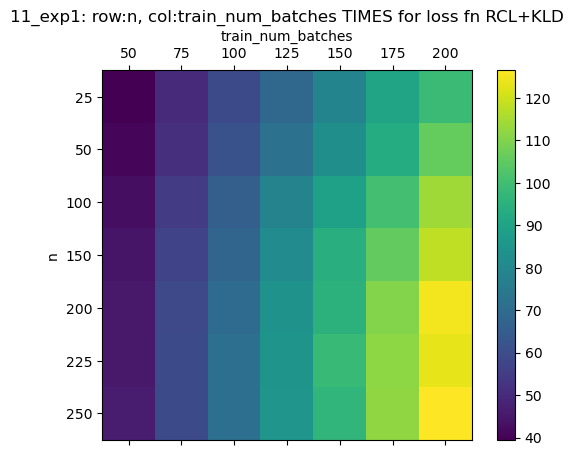

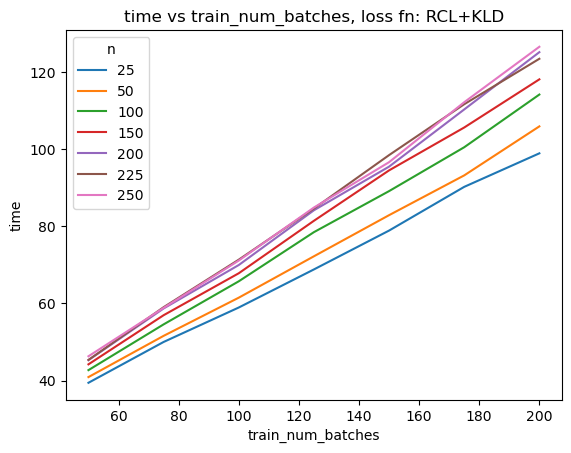

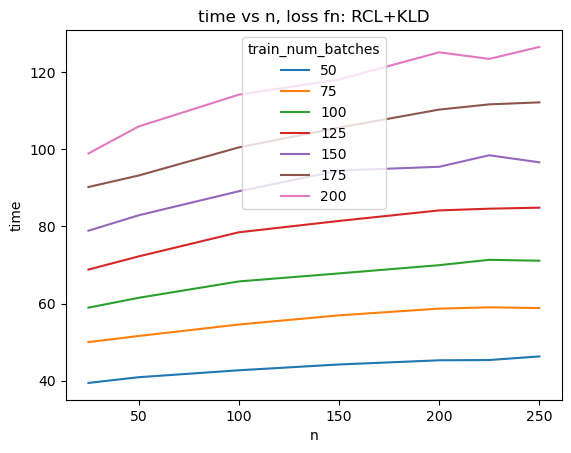

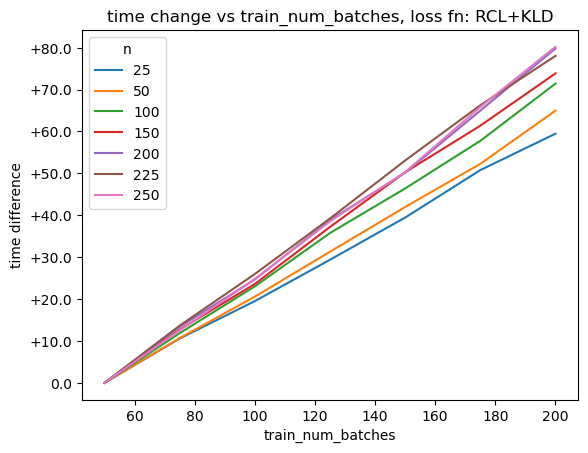

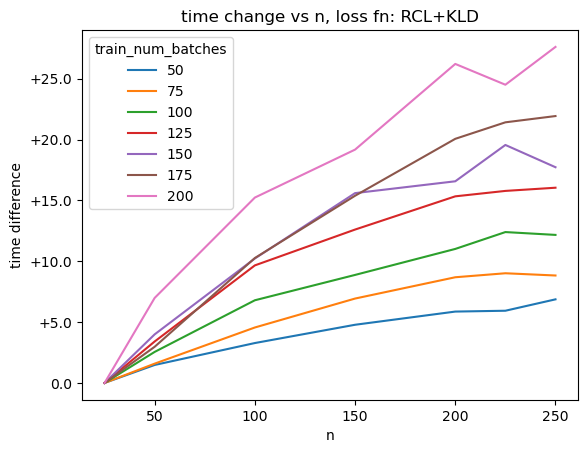

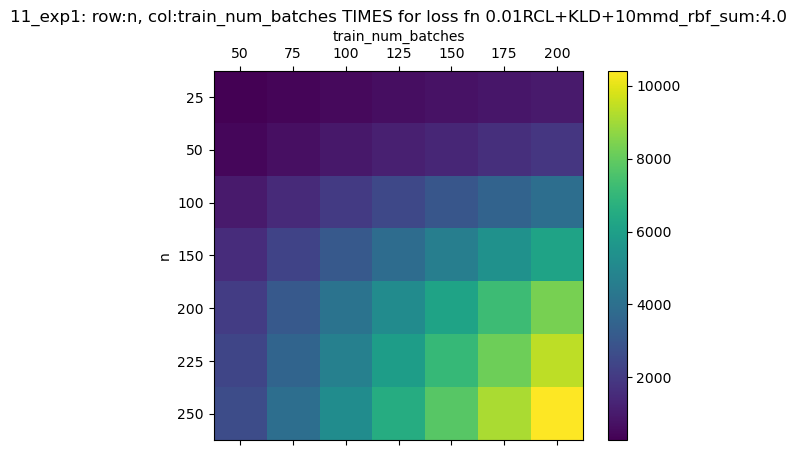

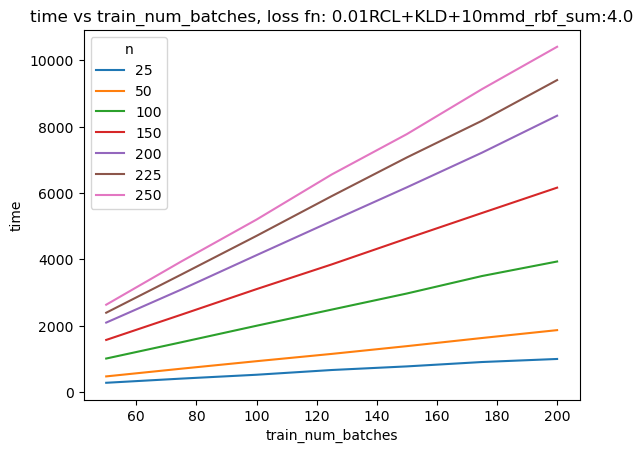

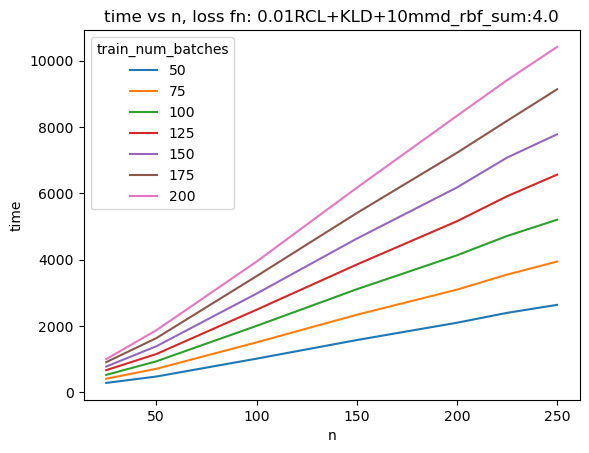

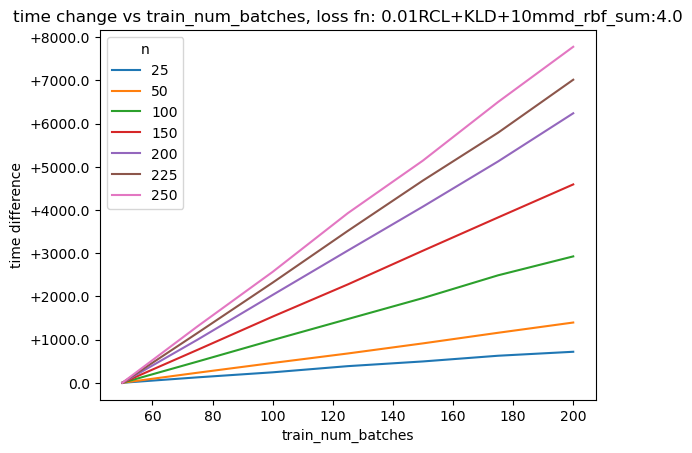

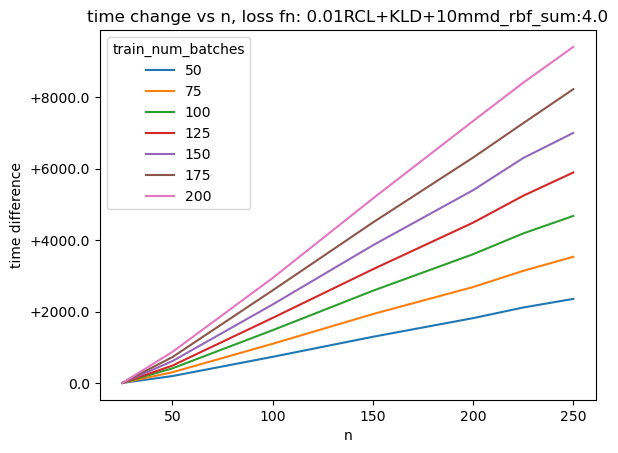

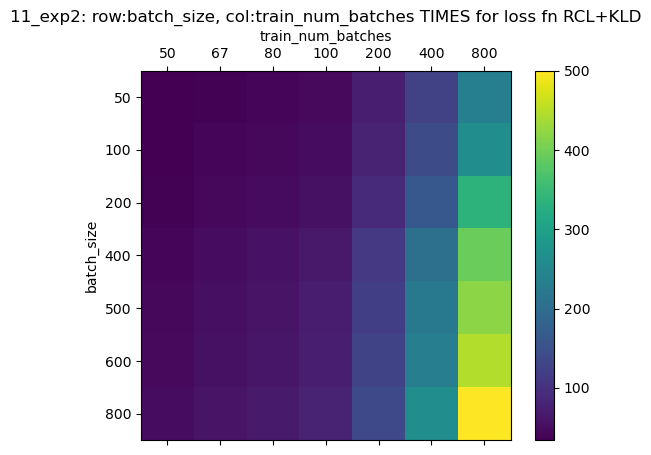

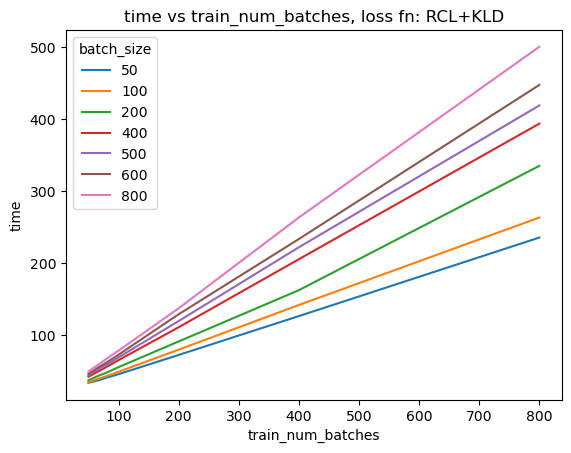

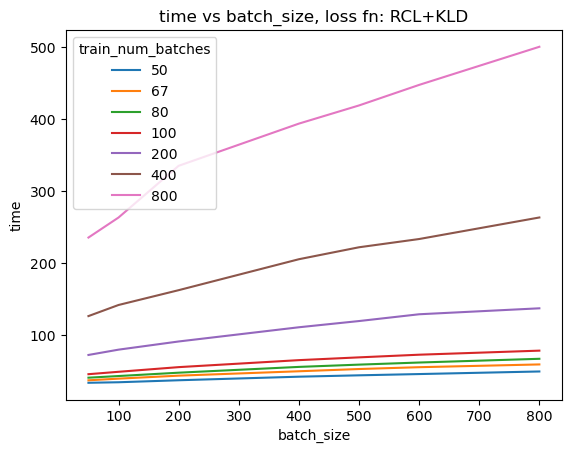

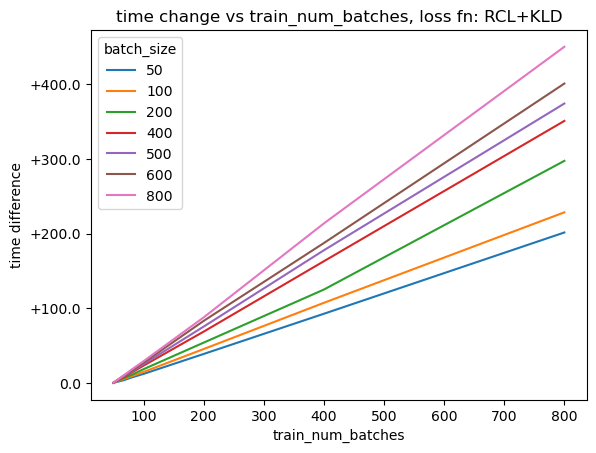

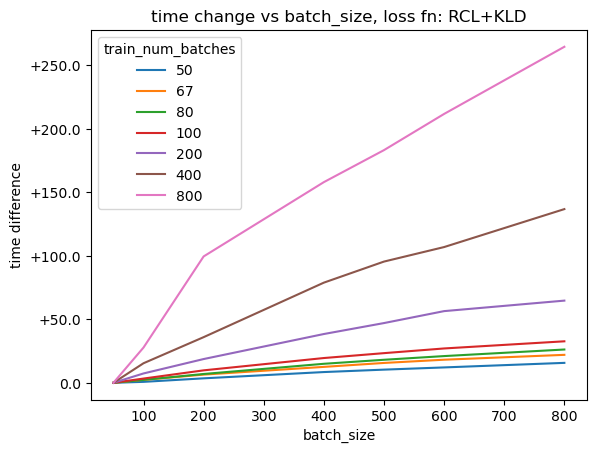

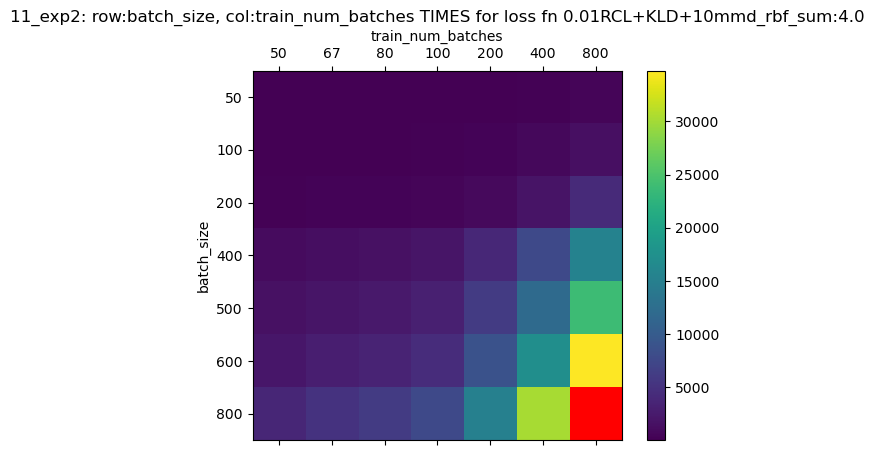

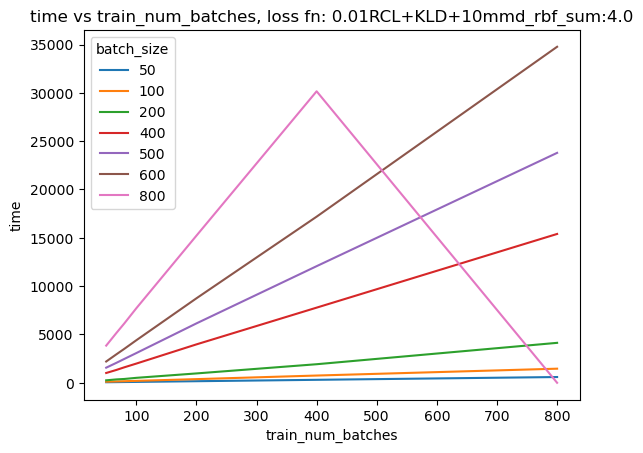

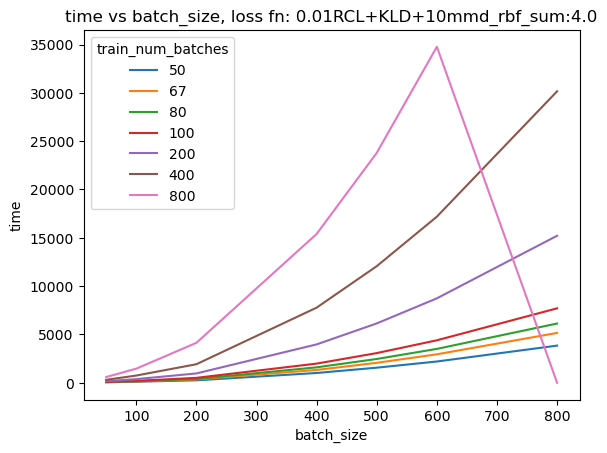

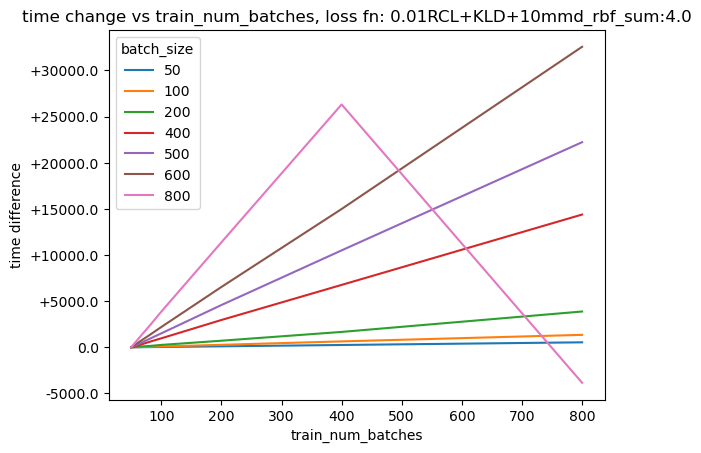

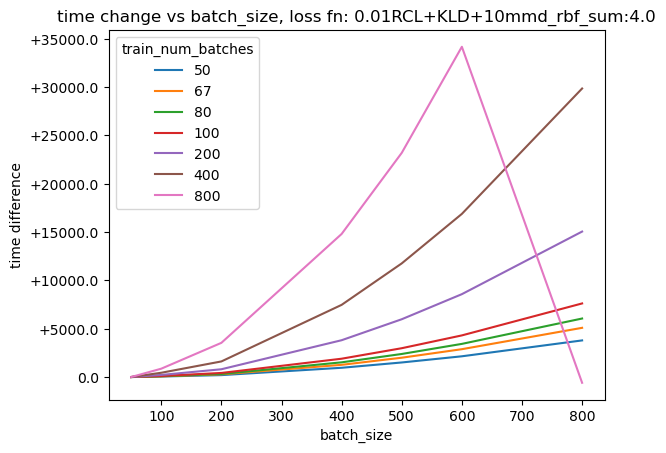

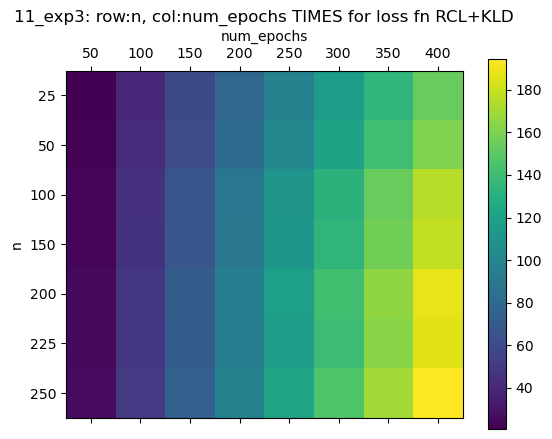

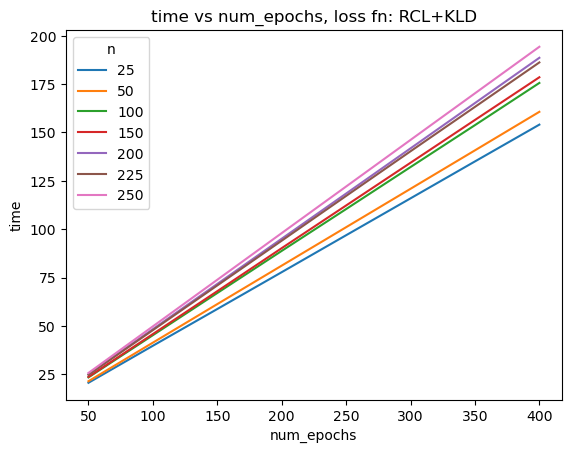

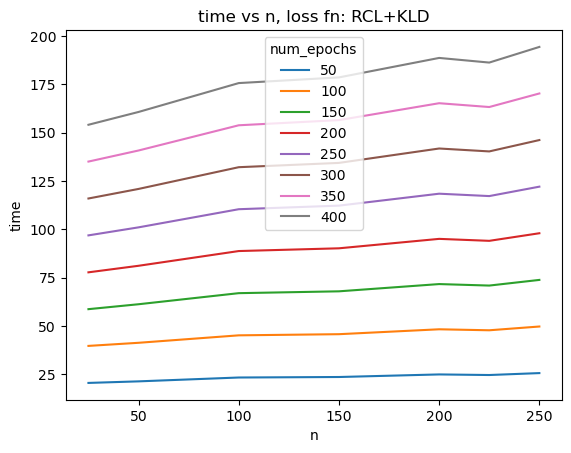

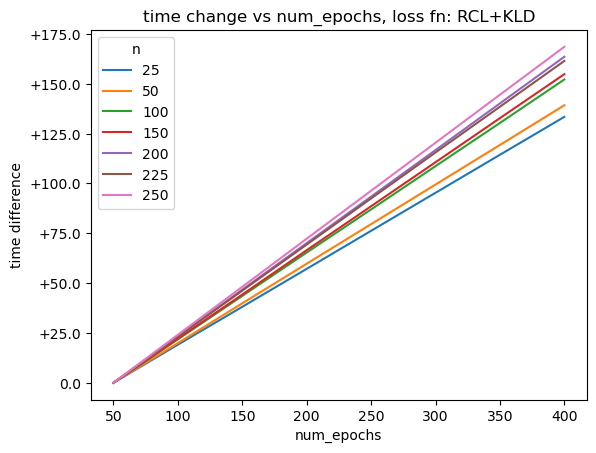

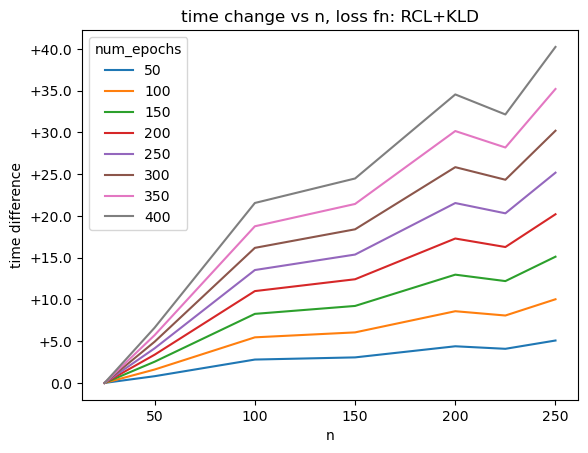

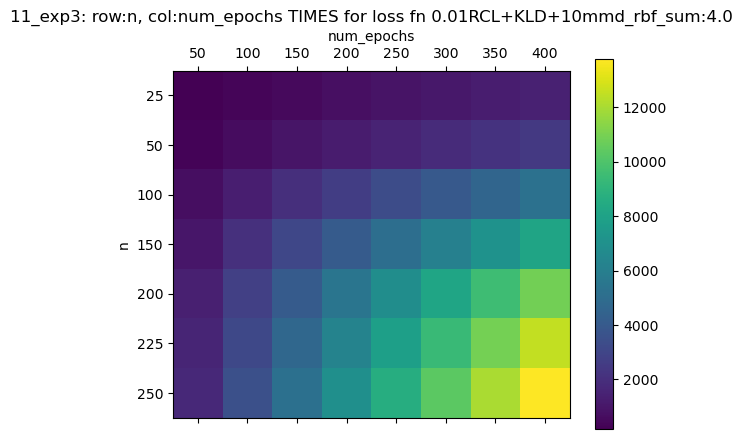

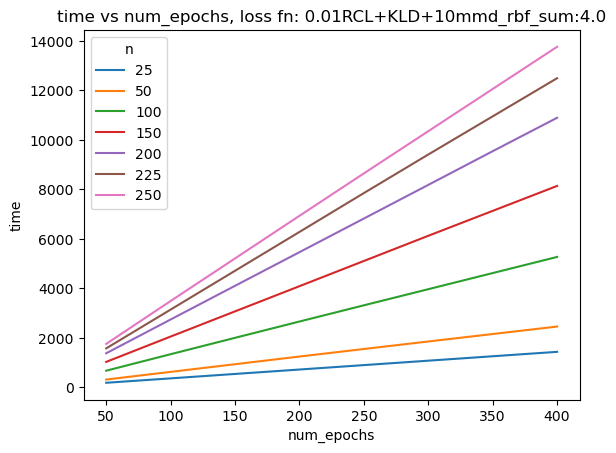

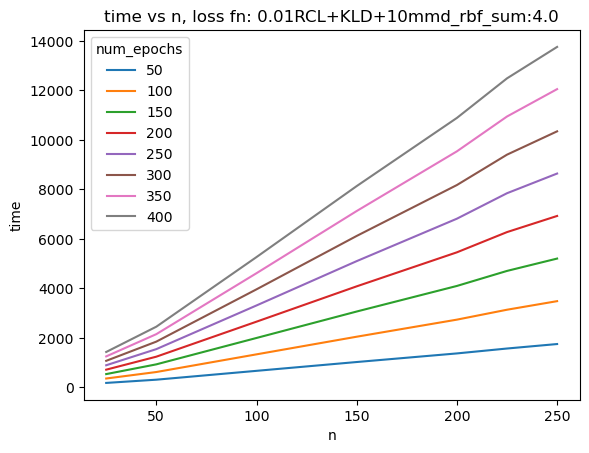

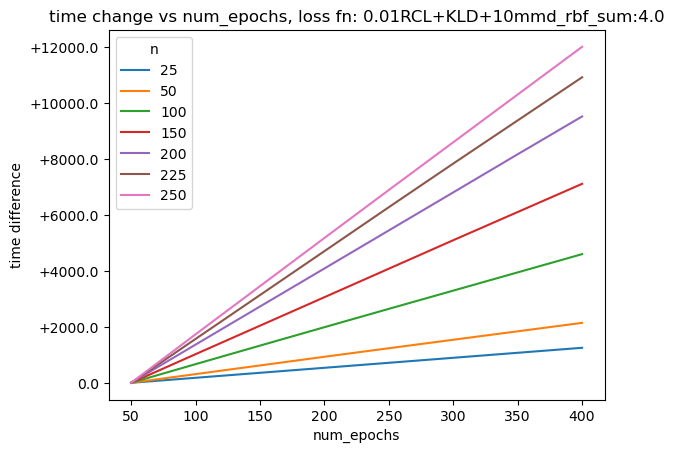

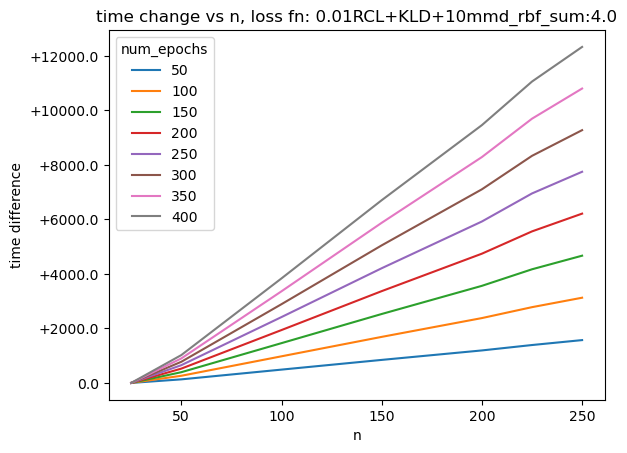

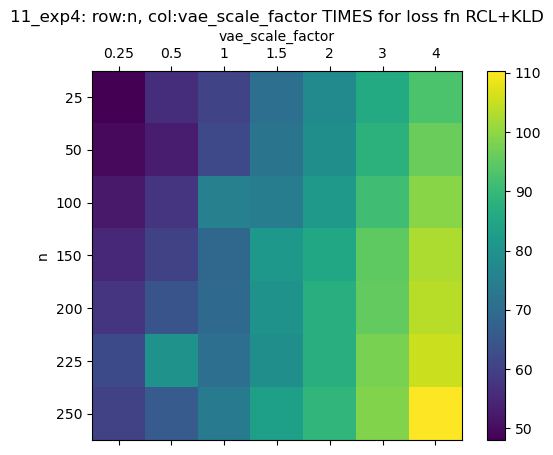

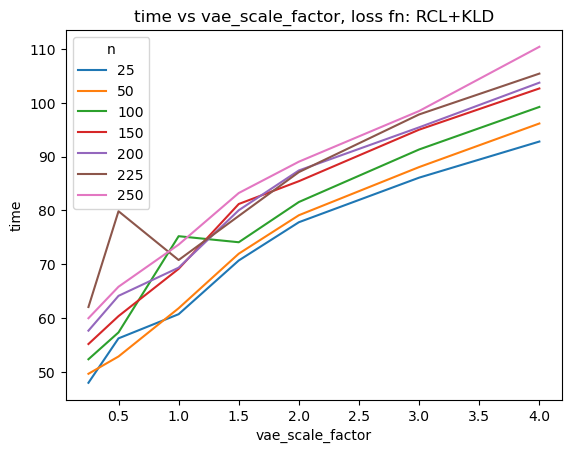

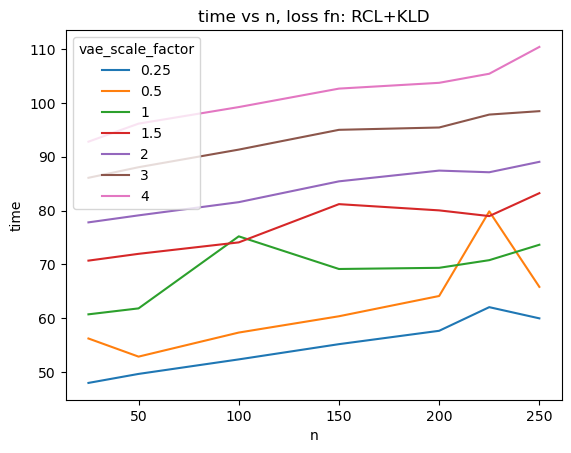

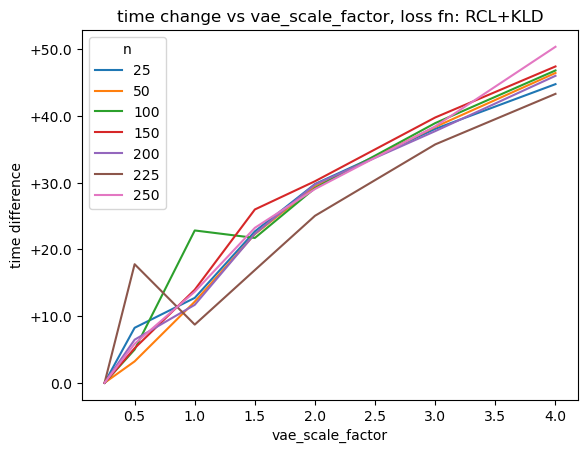

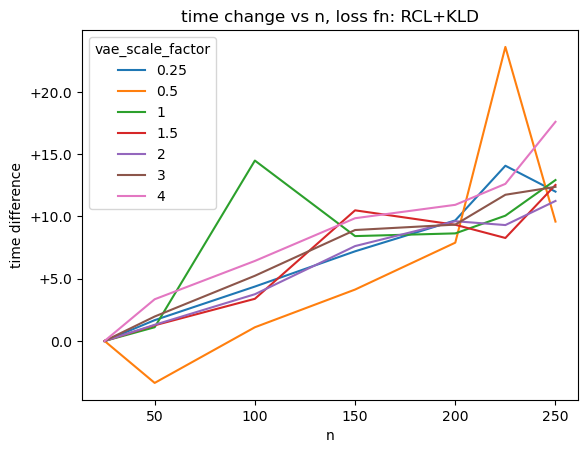

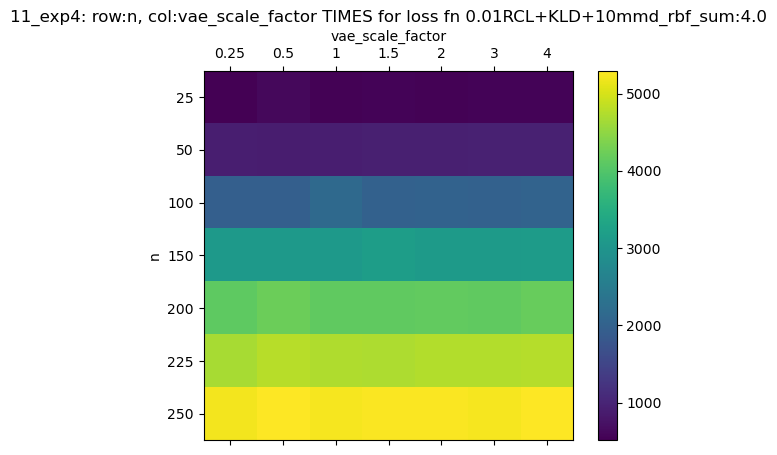

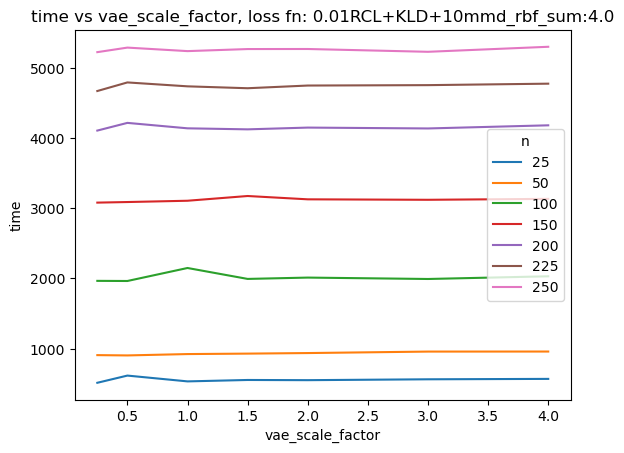

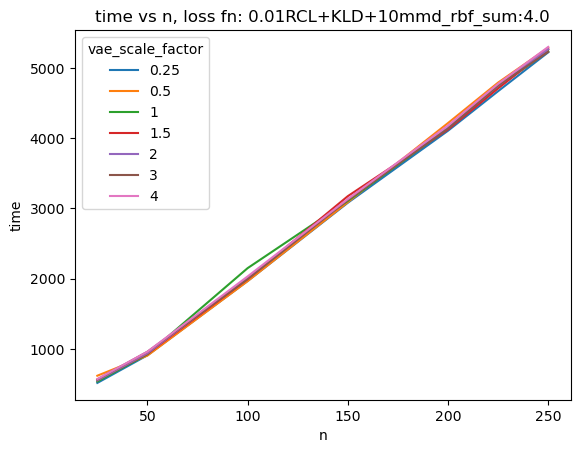

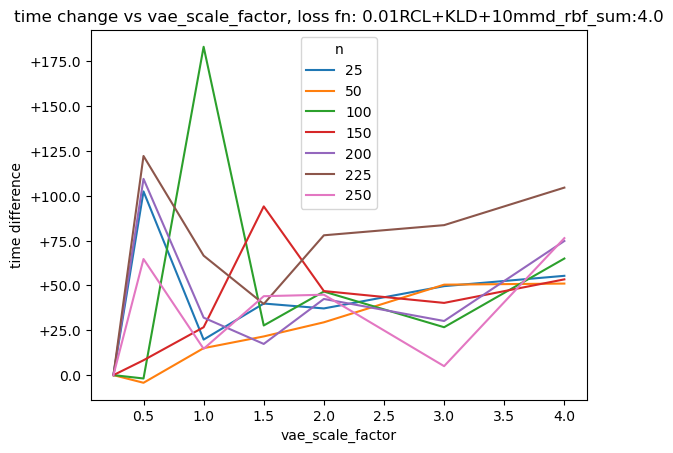

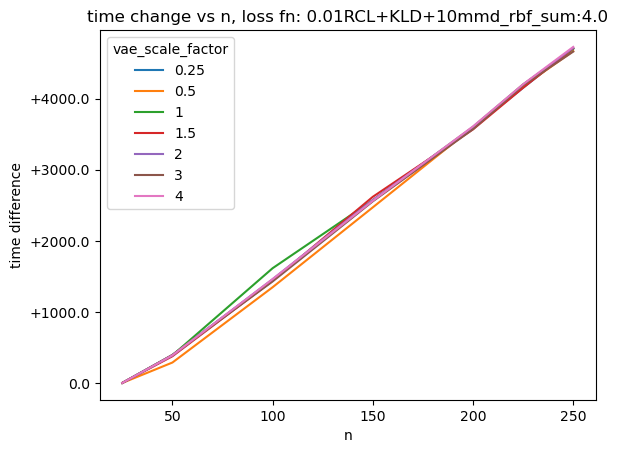

In [69]:

plot_experiment_times("11_exp1")
plot_experiment_times("11_exp2")
plot_experiment_times("11_exp3", threeIndexing=True)
plot_experiment_times("11_exp4")
